<a href="https://colab.research.google.com/github/JANAGAMNITHIN/Data-Analysis-using-python/blob/main/Daup_Lab_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (180, 3)
         count      mean     std      var
batch                                    
Batch_1     30  209.2474  3.6001  12.9606
Batch_2     30  211.2731  5.5866  31.2103
Batch_3     30  208.0451  3.4719  12.0543
Batch_4     30  214.8987  4.5441  20.6489
Batch_5     30  208.6202  4.0967  16.7827
Batch_6     30  210.6969  2.3684   5.6091

Chi-square variance test results (H0: variance = 16):
     batch   n  sample_variance  chi2_stat   p_value
0  Batch_1  30        12.960622  23.491128  0.492794
1  Batch_2  30        31.210253  56.568583  0.003236
2  Batch_3  30        12.054261  21.848348  0.347171
3  Batch_4  30        20.648880  37.426095  0.271273
4  Batch_5  30        16.782734  30.418705  0.786652
5  Batch_6  30         5.609128  10.166544  0.000943

Levene test: stat=4.0466, p=0.001687  (H0: equal variances)

One-sample t-test results (H0: mean = 210):
     batch   n  sample_mean  sample_std    t_stat   p_value
0  Batch_1  30   209.247400    3.600086 -1.14501

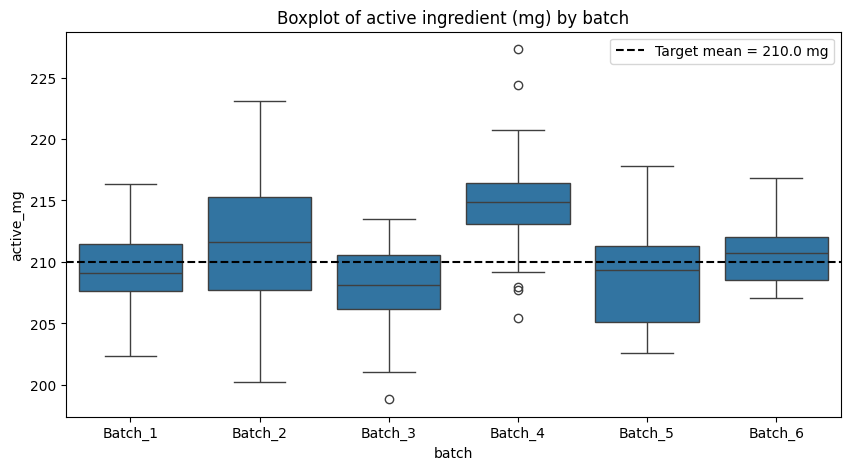

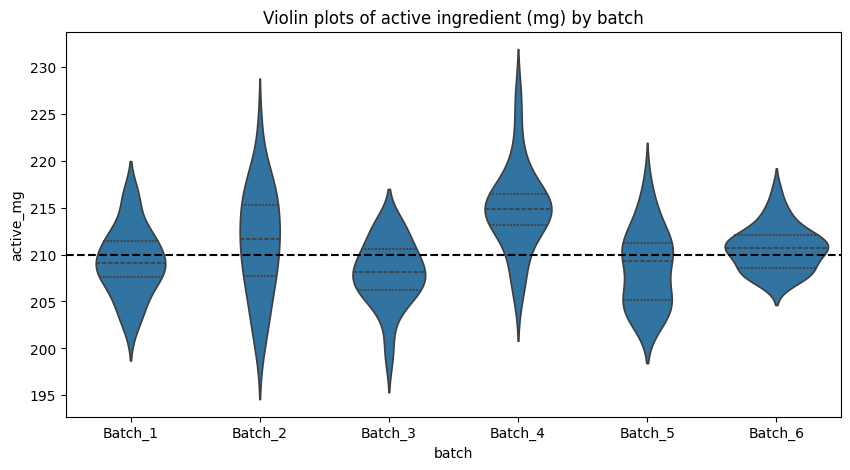

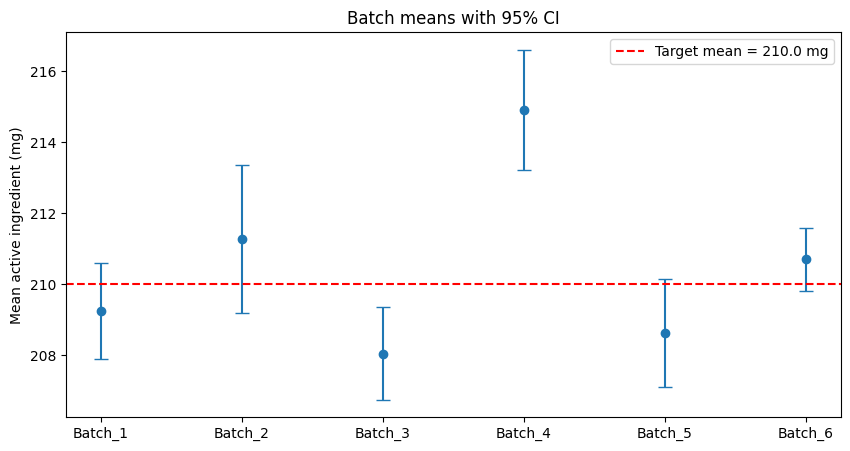

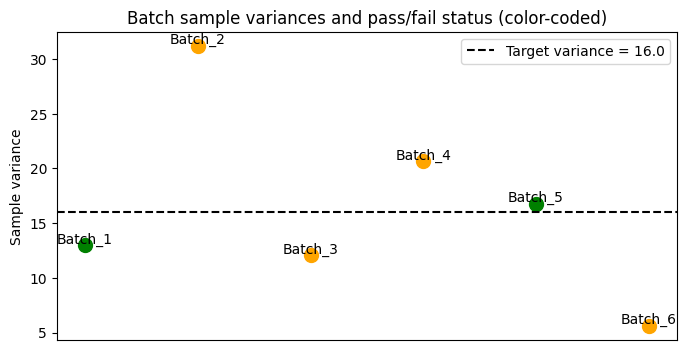


Saved combined report to multi_batch_analysis_report.csv


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
csv_path = "multi_batch_tablets.csv"
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
print(df.groupby("batch")["active_mg"].agg(['count','mean','std','var']).round(4))
target_mu = 210.0
target_sigma2 = 16.0
alpha = 0.05
variance_results = []
t_results = []
for batch, group in df.groupby("batch"):
    n = group.shape[0]
    s2 = group["active_mg"].var(ddof=1)
    chi_stat = (n - 1) * s2 / target_sigma2
    p_lower = stats.chi2.cdf(chi_stat, df=n-1)
    p_upper = 1 - p_lower
    p_two = 2 * min(p_lower, p_upper)
    variance_results.append({
        "batch": batch,
        "n": n,
        "sample_variance": s2,
        "chi2_stat": chi_stat,
        "p_value": p_two
    })

var_df = pd.DataFrame(variance_results).sort_values("batch")
print("\nChi-square variance test results (H0: variance = 16):")
print(var_df.round(6))
groups = [g["active_mg"].values for _, g in df.groupby("batch")]
levene_stat, levene_p = stats.levene(*groups, center='median')
print(f"\nLevene test: stat={levene_stat:.4f}, p={levene_p:.6f}  (H0: equal variances)")
for batch, group in df.groupby("batch"):
    t_stat, p_two = stats.ttest_1samp(group["active_mg"], popmean=target_mu)
    t_results.append({
        "batch": batch,
        "n": group.shape[0],
        "sample_mean": group["active_mg"].mean(),
        "sample_std": group["active_mg"].std(ddof=1),
        "t_stat": t_stat,
        "p_value": p_two
    })

t_df = pd.DataFrame(t_results).sort_values("batch")
print("\nOne-sample t-test results (H0: mean = 210):")
print(t_df.round(6))
m = t_df.shape[0]
rej, pvals_corr, _, _ = multipletests(t_df["p_value"], alpha=alpha, method='bonferroni')
t_df["p_bonferroni"] = pvals_corr
t_df["reject_H0_bonferroni"] = rej
print("\nAfter Bonferroni correction (alpha = {:.3f}):".format(alpha))
print(t_df.round(6))
var_df["reject_variance_H0"] = var_df["p_value"] < alpha
t_df_small = t_df[["batch", "reject_H0_bonferroni"]].rename(columns={"reject_H0_bonferroni":"reject_mean_H0"})
combined = var_df.merge(t_df_small, on="batch")
combined["status"] = combined.apply(
    lambda row: ("fail_both" if (row["reject_variance_H0"] and row["reject_mean_H0"])
                 else ("fail_variance_only" if (row["reject_variance_H0"] and not row["reject_mean_H0"])
                       else ("fail_mean_only" if (not row["reject_variance_H0"] and row["reject_mean_H0"])
                             else "pass_both"))),
    axis=1)
print("\nCombined inference summary:")
print(combined[['batch','sample_variance','p_value','reject_variance_H0','reject_mean_H0','status']].round(6))
import matplotlib.ticker as ticker
plt.rcParams.update({'figure.max_open_warning': 0})
plt.figure(figsize=(10,5))
sns.boxplot(x='batch', y='active_mg', data=df)
plt.title('Boxplot of active ingredient (mg) by batch')
plt.axhline(target_mu, color='k', linestyle='--', label=f"Target mean = {target_mu} mg")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(x='batch', y='active_mg', data=df, inner='quartile')
plt.title('Violin plots of active ingredient (mg) by batch')
plt.axhline(target_mu, color='k', linestyle='--')
plt.show()
summary = df.groupby('batch')['active_mg'].agg(['mean','std','count'])
summary['se'] = summary['std'] / np.sqrt(summary['count'])
summary['ci95'] = stats.t.ppf(1-0.025, summary['count']-1) * summary['se']
summary = summary.reset_index()

plt.figure(figsize=(10,5))
plt.errorbar(x=summary['batch'], y=summary['mean'], yerr=summary['ci95'], fmt='o', capsize=5)
plt.axhline(target_mu, color='red', linestyle='--', label=f"Target mean = {target_mu} mg")
plt.title('Batch means with 95% CI')
plt.ylabel('Mean active ingredient (mg)')
plt.legend()
plt.show()
viz = combined.copy()
viz['mean_reject'] = viz['reject_mean_H0']
viz['var_reject'] = viz['reject_variance_H0']

plt.figure(figsize=(8,4))
for i, row in viz.iterrows():
    x = i
    plt.scatter(x, row['sample_variance'], s=100,
                c=('red' if row['status']=='fail_both' else ('orange' if 'fail' in row['status'] else 'green')))
    plt.text(x, row['sample_variance']+0.2, row['batch'], ha='center')
plt.axhline(target_sigma2, color='black', linestyle='--', label=f"Target variance = {target_sigma2}")
plt.title('Batch sample variances and pass/fail status (color-coded)')
plt.ylabel('Sample variance')
plt.legend()
plt.xticks([])
plt.show()
report = combined.merge(t_df[['batch','sample_mean','sample_std','p_bonferroni']], on='batch')
report.to_csv("multi_batch_analysis_report.csv", index=False)
print("\nSaved combined report to multi_batch_analysis_report.csv")